In [ ]:
!nvidia-smi

Sun Feb 21 06:58:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.00479595days (414.37sec)


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [ ]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "drive/My Drive/ImageNet/custom_imagenet.zip" /content/
#!cp "drive/My Drive/COCO/customCOCO/customTestkai2.zip" /content/

In [ ]:
!unzip -nq "custom_imagenet.zip"
#!unzip -nq "customTestkai2.zip"

In [ ]:
def make_path_list(rootpath):
    """
    To create the list of file path about Image data and annotation data
    for training and test

    Inputs
    --------------------
    rootpath : str
        path data for data folder

    Returns
    --------------------
    *_img_list, *_anno_list
        list of path for each data
    """

    img_list = glob.glob(rootpath+'img/*/*.png')
    anno_list = glob.glob(rootpath+'anno/*/*.png')

    return img_list, anno_list


In [ ]:
rootpathTrain ='customTrainkai4/'
rootpathVal ='customTrainkai5_unseenSameClass/'
rootpathTest = 'customTestkai2/'

# Get folder name
train_img_list, train_anno_list = make_path_list(rootpathTrain)
val_img_list, val_anno_list = make_path_list(rootpathVal)
test_img_list, test_anno_list = make_path_list(rootpathTest)

In [ ]:
def str_convert(label):
    df = pd.DataFrame(({'label_' : label}))
    df['label_'] = df['label_'].astype('category')
    df.dtypes
    df['label'] = df['label_'].cat.codes
    label = df['label'].tolist()

    return label

In [ ]:
class COCODataset(data.Dataset):
    def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.label_name = [x.split("/")[2] for x in img_list]
        self.label = str_convert(self.label_name)
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        """
        Return pre-processed tensor images and labels
        """
        img, anno_class_img, label = self.pull_item(index)
        return img, anno_class_img, label
    
    def get_label_relation(self):
        df = pd.DataFrame({'name' : self.label_name, 'num' : self.label})
        classes_list=df[~df.duplicated()].sort_values(by='num')['name'].values.tolist()
        
        return classes_list

    def pull_item(self, index):
        # read image
        image_file_path = self.img_list[index]
        img = PIL.Image.open(image_file_path).convert("RGB")   # [height][width][RGB]

        # read annotation image
        anno_file_path = self.anno_list[index]
        anno_class_img = PIL.Image.open(anno_file_path)   # [height][width]

        # extend RGB channels because the channels in black&white data have same values
        anno_class_img = np.array(anno_class_img)
        anno_class_img = np.tile(anno_class_img,(3,1,1)).transpose(1,2,0)/255.0
        
        # transform
        #img = transforms.functional.to_tensor(img)
        #anno_class_img = torch.from_numpy(anno_class_img)
        img = self.transform(img)
        anno_class_img = self.transform(anno_class_img)

        # label
        label = self.label[index]
        
        return img, anno_class_img, label

In [ ]:
simple_transform = transforms.Compose([#transforms.Resize((256,256),interpolation=3),
                                       transforms.ToTensor()])
test_transform = transforms.Compose([#transforms.Resize((256,256),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = COCODataset(train_img_list, train_anno_list, phase="train",
                            transform=simple_transform)

#val_dataset = COCODataset(val_img_list, val_anno_list, phase="val",
#                          transform=test_transform)

test_dataset = COCODataset(test_img_list, test_anno_list, phase="test",
                          transform=test_transform)

In [ ]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
np.random.seed(6)
device = torch.device("cuda" if use_cuda else "cpu")
classes_list = train_dataset.get_label_relation()

batch_size = 32

In [ ]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

'# training data split to train and val\nvalidation_split = .2\n\ndataset_size = len(train_dataset)\nindices = list(range(dataset_size))\nsplit = int(np.floor(validation_split * dataset_size))\n\nnp.random.shuffle(indices)\ntrain_idx, valid_idx = indices[split:], indices[:split]\n\n# Creating PT data samplers\ntrain_sampler = torch.utils.data.SubsetRandomSampler(train_idx)\nval_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)'

In [ ]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

valloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

--------------------
(224, 224, 3)


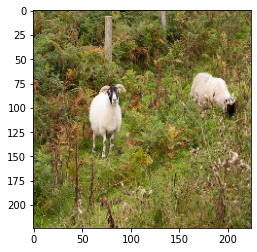

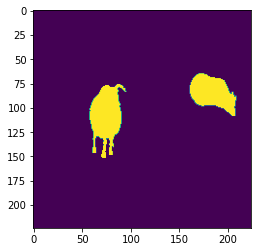

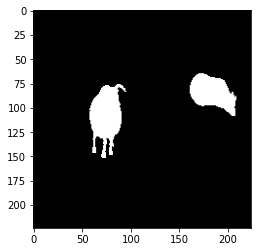

In [ ]:
index = 2
imges, anno_class_imges, label = train_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()

anno_file_path = train_anno_list[index]
anno_class_img = PIL.Image.open(anno_file_path)

#anno_class_img = np.array(anno_class_img)/255
plt.imshow(np.array(anno_class_img))
plt.show()
#print(label)
plt.imshow(anno_class_imges.numpy().transpose((1, 2, 0)))
plt.show()

In [ ]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename="confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [ ]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

### Network model

In [ ]:
class TinyCNN(nn.Module):
    """
    TinyCNN: https://arxiv.org/abs/1911.06777v1

    fc1, fc2 should be modified for each image size and class num.

    model=TinyCNN()
    model.fc1 = nn.Linear(in_features=128 * FC_H * FC_W, out_features=N_CLASSES)
    model.fc2 = nn.Linear(in_features=100, out_features=N_CLASSES)
    """
    def __init__(self, DROPOUT=False):
        super(TinyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3,   32,  3, 1, 1, bias=False)
        self.conv2 = nn.Conv2d(32,  64,  3, 1, 1, bias=False)
        self.conv3 = nn.Conv2d(64,  128, 3, 1, 1, bias=False)
        self.conv4 = nn.Conv2d(128, 128, 3, 1, 1, bias=False)

        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2)
        
        self.fc1 = nn.Linear(128 * 8 * 8, 100)
        self.fc2 = nn.Linear(100, 10)

        self.dropout_control = DROPOUT
        self.fc1_drop = nn.Dropout2d(p=0.5)
        self.fc2_drop = nn.Dropout2d(p=0.4)

    def encode(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        return x

    def classify(self, x):
        x = x.view(x.size(0),-1)

        if(self.dropout_control):
            x = self.relu(self.fc1_drop(self.fc1(x)))
            x = self.relu(self.fc2_drop(self.fc2(x)))
        else:
            x = self.relu(self.fc1(x))
            # For easy replacement of label sizes
            # activation is assigned to forward output
            x = self.fc2(x)

        return x

    def forward(self, x):
        x = self.encode(x)
        x = self.classify(x)

        return self.relu(x)

### CONST data

In [ ]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 2
else:
    NUM_EPOCS = 50

N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

### Model preparation

In [ ]:
# TinyCNN model instance set
model=TinyCNN()

# FC layer input&output size change
model.fc1 = nn.Linear(in_features=128 * FC_H * FC_W, out_features=100)
model.fc2 = nn.Linear(in_features=100, out_features=N_CLASSES)

model.cuda()

TinyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=20, bias=True)
  (fc1_drop): Dropout2d(p=0.5, inplace=False)
  (fc2_drop): Dropout2d(p=0.4, inplace=False)
)

### Loss function

In [ ]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### Optimization method

In [ ]:
# Optimization setting
optimizer = optim.Adam(model.parameters(),lr=0.001)

### Training & Test for model

In [ ]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):

    best_model=model; best_accuracy = 0;
    stats = []; training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    for epoch in range(num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_corrects = 0  # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_corrects += preds.eq(labels.view_as(preds)).sum().item()

            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects / len(dataloaders_dict[phase].dataset) *100.

            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if epoch%5==0:
            name = name+"_epoch"+str(epoch)+".pth"
            path = F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{name}"
            torch.save(model.state_dict(), path)
        print('-------------')

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

In [ ]:
name = "01_simple"
best_model, stats = train_model(model, dataloaders_dict, criterion, optimizer, NUM_EPOCS, name, "simple", DEBUG)

Epoch 1/50
-------------



train Loss: 0.0936 Acc: 6.5000



val Loss: 0.0940 Acc: 7.8000
-------------
Epoch 2/50
-------------



train Loss: 0.0930 Acc: 7.5667



val Loss: 0.0914 Acc: 9.5500
-------------
Epoch 3/50
-------------



train Loss: 0.0895 Acc: 12.3167



val Loss: 0.0876 Acc: 14.5000
-------------
Epoch 4/50
-------------



train Loss: 0.0851 Acc: 19.2000



val Loss: 0.0874 Acc: 17.1000
-------------
Epoch 5/50
-------------



train Loss: 0.0797 Acc: 25.9500



val Loss: 0.0846 Acc: 20.9000
-------------
Epoch 6/50
-------------



train Loss: 0.0727 Acc: 32.2667



val Loss: 0.0842 Acc: 22.9500
-------------
Epoch 7/50
-------------



train Loss: 0.0656 Acc: 38.8500



val Loss: 0.0879 Acc: 22.5000
-------------
Epoch 8/50
-------------



train Loss: 0.0592 Acc: 43.3667



val Loss: 0.0902 Acc: 21.1500
-------------
Epoch 9/50
-------------



train Loss: 0.0539 Acc: 47.8833



val Loss: 0.0940 Acc: 19.9000
-------------
Epoch 10/50
-------------



train Loss: 0.0507 Acc: 50.0000



val Loss: 0.0966 Acc: 19.1500
-------------
Epoch 11/50
-------------



train Loss: 0.0478 Acc: 52.2167



val Loss: 0.1111 Acc: 19.4500
-------------
Epoch 12/50
-------------



train Loss: 0.0463 Acc: 53.1333



val Loss: 0.1069 Acc: 18.5500
-------------
Epoch 13/50
-------------



train Loss: 0.0455 Acc: 53.6833



val Loss: 0.1131 Acc: 18.1500
-------------
Epoch 14/50
-------------



train Loss: 0.0462 Acc: 53.6000



val Loss: 0.1089 Acc: 17.6500
-------------
Epoch 15/50
-------------



train Loss: 0.0463 Acc: 53.5833



val Loss: 0.1148 Acc: 18.8500
-------------
Epoch 16/50
-------------



train Loss: 0.0448 Acc: 54.3167



val Loss: 0.1203 Acc: 18.0000
-------------
Epoch 17/50
-------------



train Loss: 0.0441 Acc: 54.7500



val Loss: 0.1226 Acc: 18.0000
-------------
Epoch 18/50
-------------



train Loss: 0.0434 Acc: 55.0833



val Loss: 0.1242 Acc: 17.9500
-------------
Epoch 19/50
-------------



train Loss: 0.0440 Acc: 54.9167



val Loss: 0.1245 Acc: 16.5500
-------------
Epoch 20/50
-------------



train Loss: 0.0444 Acc: 54.7000



val Loss: 0.1376 Acc: 18.2500
-------------
Epoch 21/50
-------------



train Loss: 0.0450 Acc: 54.2000



val Loss: 0.1242 Acc: 17.5500
-------------
Epoch 22/50
-------------



train Loss: 0.0444 Acc: 54.7000



val Loss: 0.1409 Acc: 18.9000
-------------
Epoch 23/50
-------------



train Loss: 0.0440 Acc: 55.0667



val Loss: 0.1289 Acc: 17.7500
-------------
Epoch 24/50
-------------



train Loss: 0.0432 Acc: 55.4500



val Loss: 0.1259 Acc: 17.5500
-------------
Epoch 25/50
-------------



train Loss: 0.0429 Acc: 55.6667



val Loss: 0.1303 Acc: 17.3500
-------------
Epoch 26/50
-------------



train Loss: 0.0427 Acc: 55.6667



val Loss: 0.1288 Acc: 17.2500
-------------
Epoch 27/50
-------------



train Loss: 0.0432 Acc: 55.5167



val Loss: 0.1293 Acc: 17.0000
-------------
Epoch 28/50
-------------



train Loss: 0.0442 Acc: 54.6833



val Loss: 0.1224 Acc: 17.6000
-------------
Epoch 29/50
-------------



train Loss: 0.0438 Acc: 55.2333



val Loss: 0.1310 Acc: 17.0500
-------------
Epoch 30/50
-------------



train Loss: 0.0433 Acc: 55.6500



val Loss: 0.1263 Acc: 18.0000
-------------
Epoch 31/50
-------------



train Loss: 0.0427 Acc: 55.7500



val Loss: 0.1312 Acc: 16.6500
-------------
Epoch 32/50
-------------



train Loss: 0.0424 Acc: 55.8333



val Loss: 0.1459 Acc: 17.4500
-------------
Epoch 33/50
-------------



train Loss: 0.0425 Acc: 55.6833



val Loss: 0.1437 Acc: 17.2000
-------------
Epoch 34/50
-------------



train Loss: 0.0433 Acc: 55.4500



val Loss: 0.1509 Acc: 17.8000
-------------
Epoch 35/50
-------------



train Loss: 0.0433 Acc: 55.3167



val Loss: 0.1419 Acc: 16.9000
-------------
Epoch 36/50
-------------



train Loss: 0.0432 Acc: 55.6667



val Loss: 0.1304 Acc: 17.0500
-------------
Epoch 37/50
-------------



train Loss: 0.0427 Acc: 55.7500



val Loss: 0.1667 Acc: 19.2000
-------------
Epoch 38/50
-------------



train Loss: 0.0426 Acc: 55.8667



val Loss: 0.1470 Acc: 18.1500
-------------
Epoch 39/50
-------------



train Loss: 0.0431 Acc: 55.5333



val Loss: 0.1552 Acc: 16.8000
-------------
Epoch 40/50
-------------



train Loss: 0.0435 Acc: 55.5667



val Loss: 0.1518 Acc: 15.9500
-------------
Epoch 41/50
-------------



train Loss: 0.0432 Acc: 55.6000



val Loss: 0.1226 Acc: 16.5500
-------------
Epoch 42/50
-------------



train Loss: 0.0428 Acc: 55.6500



val Loss: 0.1343 Acc: 15.5000
-------------
Epoch 43/50
-------------



train Loss: 0.0446 Acc: 54.9333



val Loss: 0.1316 Acc: 16.5500
-------------
Epoch 44/50
-------------



train Loss: 0.0427 Acc: 55.8500



val Loss: 0.1368 Acc: 17.5500
-------------
Epoch 45/50
-------------



train Loss: 0.0422 Acc: 56.0500



val Loss: 0.1311 Acc: 16.2000
-------------
Epoch 46/50
-------------



train Loss: 0.0424 Acc: 56.0000



val Loss: 0.1478 Acc: 17.3500
-------------
Epoch 47/50
-------------



train Loss: 0.0429 Acc: 55.6167



val Loss: 0.1588 Acc: 17.0500
-------------
Epoch 48/50
-------------



train Loss: 0.0428 Acc: 55.8667



val Loss: 0.1289 Acc: 17.4000
-------------
Epoch 49/50
-------------



train Loss: 0.0423 Acc: 56.0833



val Loss: 0.1319 Acc: 16.9000
-------------
Epoch 50/50
-------------



train Loss: 0.0422 Acc: 56.1667



val Loss: 0.1392 Acc: 17.7500
-------------
Lowest training loss 0.042157212674617764
Lowest validation loss 0.0842177757024765
Highest training accuracy 56.166666666666664
Highest validation accuracy 22.95
-------------


In [ ]:
# Save weights
path = F"/content/drive/My Drive/Colab Notebooks/PhD/simple/{name}.pth"
torch.save(best_model.state_dict(), path)

/content/drive/My Drive/Colab Notebooks/Graphs/simple_Loss _.pngsimple_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/simple_Accuracy _.pngsimple_Accuracy _.png


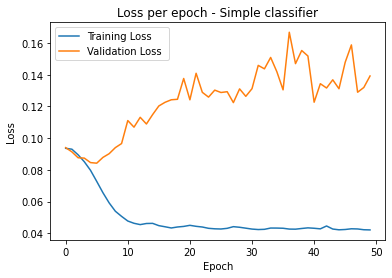

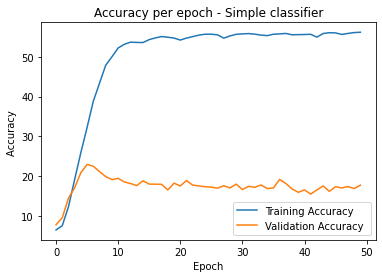

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats[1],stats[3],NUM_EPOCS,"Accuracy ",name)

## VGG16 transfer learning

In [ ]:
# Load pre-trained VGG-16
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

# Replacement last layer output for 20 classes
net.classifier[6] = nn.Linear(in_features=4096, out_features=N_CLASSES)

net.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Store parameters through transfer learning, which are re-trained
params_to_update = []

# Re-trained params
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# Non re-trained params keep their grads
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# Check params_to_update contents
print("-----------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
-----------
[Parameter containing:
tensor([[ 0.0134, -0.0059,  0.0141,  ...,  0.0036,  0.0102,  0.0128],
        [-0.0141, -0.0136,  0.0122,  ..., -0.0084,  0.0143,  0.0067],
        [ 0.0116, -0.0027, -0.0018,  ...,  0.0029, -0.0026,  0.0058],
        ...,
        [-0.0006, -0.0020, -0.0069,  ..., -0.0014,  0.0096, -0.0097],
        [ 0.0089, -0.0073, -0.0126,  ...,  0.0156,  0.0125,  0.0156],
        [ 0.0137,  0.0085, -0.0042,  ...,  0.0080, -0.0002,  0.0139]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.0111,  0.0029,  0.0147,  0.0026, -0.0090,  0.0045,  0.0038,  0.0040,
        -0.0147, -0.0113, -0.0150, -0.0032, -0.0071,  0.0055,  0.0088,  0.0153,
        -0.0070,  0.0100, -0.0036,  0.0108], device='cuda:0',
       requires_grad=True)]


### VGG optimizer

In [ ]:
vgg_optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [ ]:
name = "01_VGG_transfer"
best_vgg, stats_vgg = train_model(net, dataloaders_dict, criterion, vgg_optimizer, NUM_EPOCS, name, "VGG_transfer", DEBUG)

Epoch 1/50
-------------



train Loss: 0.0426 Acc: 61.4000



val Loss: 0.0268 Acc: 76.0000
-------------
Epoch 2/50
-------------



train Loss: 0.0270 Acc: 73.3500



val Loss: 0.0240 Acc: 76.5500
-------------
Epoch 3/50
-------------



train Loss: 0.0240 Acc: 76.6500



val Loss: 0.0229 Acc: 76.8500
-------------
Epoch 4/50
-------------



train Loss: 0.0227 Acc: 77.3500



val Loss: 0.0225 Acc: 77.2500
-------------
Epoch 5/50
-------------



train Loss: 0.0214 Acc: 78.0667



val Loss: 0.0218 Acc: 77.7000
-------------
Epoch 6/50
-------------



train Loss: 0.0209 Acc: 78.4167



val Loss: 0.0218 Acc: 77.8000
-------------
Epoch 7/50
-------------



train Loss: 0.0202 Acc: 79.5167



val Loss: 0.0216 Acc: 78.2500
-------------
Epoch 8/50
-------------



train Loss: 0.0198 Acc: 79.2000



val Loss: 0.0215 Acc: 78.1000
-------------
Epoch 9/50
-------------



train Loss: 0.0190 Acc: 80.4667



val Loss: 0.0216 Acc: 77.8000
-------------
Epoch 10/50
-------------



train Loss: 0.0188 Acc: 80.6833



val Loss: 0.0216 Acc: 78.5500
-------------
Epoch 11/50
-------------



train Loss: 0.0181 Acc: 81.2000



val Loss: 0.0216 Acc: 77.8500
-------------
Epoch 12/50
-------------



train Loss: 0.0179 Acc: 81.8167



val Loss: 0.0214 Acc: 78.1500
-------------
Epoch 13/50
-------------



train Loss: 0.0180 Acc: 81.1833



val Loss: 0.0214 Acc: 77.9500
-------------
Epoch 14/50
-------------



train Loss: 0.0172 Acc: 81.9667



val Loss: 0.0214 Acc: 78.3500
-------------
Epoch 15/50
-------------



train Loss: 0.0168 Acc: 82.4833



val Loss: 0.0213 Acc: 77.9000
-------------
Epoch 16/50
-------------



train Loss: 0.0166 Acc: 82.7333



val Loss: 0.0213 Acc: 78.2500
-------------
Epoch 17/50
-------------



train Loss: 0.0166 Acc: 82.9833



val Loss: 0.0214 Acc: 78.1500
-------------
Epoch 18/50
-------------



train Loss: 0.0159 Acc: 83.6500



val Loss: 0.0214 Acc: 78.2500
-------------
Epoch 19/50
-------------



train Loss: 0.0164 Acc: 82.9000



val Loss: 0.0213 Acc: 78.5500
-------------
Epoch 20/50
-------------



train Loss: 0.0155 Acc: 84.0833



val Loss: 0.0213 Acc: 78.0000
-------------
Epoch 21/50
-------------



train Loss: 0.0154 Acc: 83.9000



val Loss: 0.0216 Acc: 77.8500
-------------
Epoch 22/50
-------------



train Loss: 0.0158 Acc: 83.6500



val Loss: 0.0212 Acc: 78.3500
-------------
Epoch 23/50
-------------



train Loss: 0.0153 Acc: 83.9167



val Loss: 0.0215 Acc: 77.9000
-------------
Epoch 24/50
-------------



train Loss: 0.0151 Acc: 84.3833



val Loss: 0.0211 Acc: 78.6000
-------------
Epoch 25/50
-------------



train Loss: 0.0151 Acc: 84.5000



val Loss: 0.0215 Acc: 78.1000
-------------
Epoch 26/50
-------------



train Loss: 0.0149 Acc: 84.5500



val Loss: 0.0213 Acc: 78.0500
-------------
Epoch 27/50
-------------



train Loss: 0.0144 Acc: 85.2833



val Loss: 0.0215 Acc: 77.9000
-------------
Epoch 28/50
-------------



train Loss: 0.0143 Acc: 84.9000



val Loss: 0.0212 Acc: 78.1000
-------------
Epoch 29/50
-------------



train Loss: 0.0143 Acc: 84.9167



val Loss: 0.0214 Acc: 77.6000
-------------
Epoch 30/50
-------------



train Loss: 0.0140 Acc: 85.1833



val Loss: 0.0216 Acc: 77.5000
-------------
Epoch 31/50
-------------



train Loss: 0.0142 Acc: 84.9667



val Loss: 0.0217 Acc: 78.3000
-------------
Epoch 32/50
-------------



train Loss: 0.0139 Acc: 84.9667



val Loss: 0.0214 Acc: 78.2000
-------------
Epoch 33/50
-------------



train Loss: 0.0139 Acc: 85.6667



val Loss: 0.0215 Acc: 78.3000
-------------
Epoch 34/50
-------------



train Loss: 0.0139 Acc: 85.4500



val Loss: 0.0214 Acc: 78.3000
-------------
Epoch 35/50
-------------



train Loss: 0.0136 Acc: 85.4500



val Loss: 0.0215 Acc: 78.1500
-------------
Epoch 36/50
-------------



train Loss: 0.0138 Acc: 85.4000



val Loss: 0.0214 Acc: 78.8000
-------------
Epoch 37/50
-------------



train Loss: 0.0137 Acc: 85.2167



val Loss: 0.0213 Acc: 78.6500
-------------
Epoch 38/50
-------------



train Loss: 0.0137 Acc: 85.5833



val Loss: 0.0212 Acc: 78.1500
-------------
Epoch 39/50
-------------



train Loss: 0.0136 Acc: 85.6500



val Loss: 0.0212 Acc: 78.7500
-------------
Epoch 40/50
-------------



train Loss: 0.0134 Acc: 85.9333



val Loss: 0.0214 Acc: 78.3000
-------------
Epoch 41/50
-------------



train Loss: 0.0130 Acc: 86.5333



val Loss: 0.0215 Acc: 78.0500
-------------
Epoch 42/50
-------------



train Loss: 0.0129 Acc: 86.6167



val Loss: 0.0217 Acc: 78.3000
-------------
Epoch 43/50
-------------



train Loss: 0.0128 Acc: 86.3167



val Loss: 0.0213 Acc: 78.6000
-------------
Epoch 44/50
-------------



train Loss: 0.0131 Acc: 85.8500



val Loss: 0.0213 Acc: 78.2500
-------------
Epoch 45/50
-------------



train Loss: 0.0125 Acc: 86.6667



val Loss: 0.0215 Acc: 78.2500
-------------
Epoch 46/50
-------------



train Loss: 0.0133 Acc: 86.0833



val Loss: 0.0213 Acc: 78.3000
-------------
Epoch 47/50
-------------



train Loss: 0.0124 Acc: 86.4500



val Loss: 0.0214 Acc: 78.5000
-------------
Epoch 48/50
-------------



train Loss: 0.0129 Acc: 86.1833



val Loss: 0.0216 Acc: 78.1000
-------------
Epoch 49/50
-------------



train Loss: 0.0124 Acc: 87.0500



val Loss: 0.0214 Acc: 78.2000
-------------
Epoch 50/50
-------------



train Loss: 0.0123 Acc: 87.1833



val Loss: 0.0215 Acc: 78.1000
-------------
Lowest training loss 0.012292653520901997
Lowest validation loss 0.021120032101869583
Highest training accuracy 87.18333333333334
Highest validation accuracy 78.8
-------------


In [ ]:
# Save weights
path = F"/content/drive/My Drive/Colab Notebooks/PhD/VGG_transfer/{name}.pth"
torch.save(best_vgg.state_dict(), path)

/content/drive/My Drive/Colab Notebooks/Graphs/VGG_transfer_Loss _.pngVGG_transfer_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/VGG_transfer_Accuracy _.pngVGG_transfer_Accuracy _.png


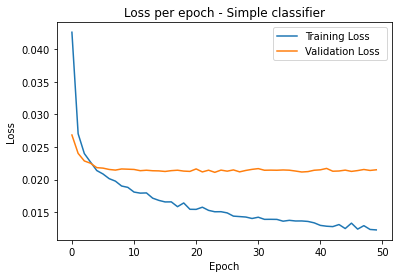

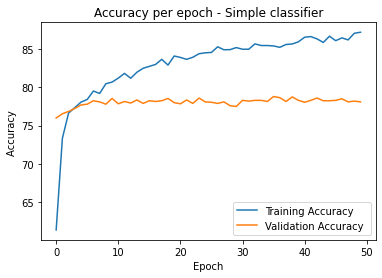

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats_vgg[0],stats_vgg[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats_vgg[1],stats_vgg[3],NUM_EPOCS,"Accuracy ",name)

### VGG16 fine tuning

In [ ]:
# Load pre-trained VGG-16
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

# Replacement last layer output for 20 classes
net.classifier[6] = nn.Linear(in_features=4096, out_features=N_CLASSES)

net.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Store parameters through transfer learning, which are re-trained
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# Re-trained params
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# Non re-trained params keep their grads
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1 stores：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2 stores：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3 stores：", name)

    else:
        param.requires_grad = False
        print("Freazed：", name)

params_to_update_1 stores： features.0.weight
params_to_update_1 stores： features.0.bias
params_to_update_1 stores： features.2.weight
params_to_update_1 stores： features.2.bias
params_to_update_1 stores： features.5.weight
params_to_update_1 stores： features.5.bias
params_to_update_1 stores： features.7.weight
params_to_update_1 stores： features.7.bias
params_to_update_1 stores： features.10.weight
params_to_update_1 stores： features.10.bias
params_to_update_1 stores： features.12.weight
params_to_update_1 stores： features.12.bias
params_to_update_1 stores： features.14.weight
params_to_update_1 stores： features.14.bias
params_to_update_1 stores： features.17.weight
params_to_update_1 stores： features.17.bias
params_to_update_1 stores： features.19.weight
params_to_update_1 stores： features.19.bias
params_to_update_1 stores： features.21.weight
params_to_update_1 stores： features.21.bias
params_to_update_1 stores： features.24.weight
params_to_update_1 stores： features.24.bias
params_to_update_1

In [ ]:
vgg_optimizer2 = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)

In [ ]:
name = "01_VGG_fine"
best_vgg2, stats_vgg2 = train_model(net, dataloaders_dict, criterion, vgg_optimizer2, NUM_EPOCS, name, "VGG_fine", DEBUG)

Epoch 1/50
-------------



train Loss: 0.0341 Acc: 67.1000



val Loss: 0.0180 Acc: 81.5000
-------------
Epoch 2/50
-------------



train Loss: 0.0167 Acc: 83.2500



val Loss: 0.0165 Acc: 83.4000
-------------
Epoch 3/50
-------------



train Loss: 0.0124 Acc: 87.0333



val Loss: 0.0159 Acc: 84.0000
-------------
Epoch 4/50
-------------



train Loss: 0.0095 Acc: 90.7000



val Loss: 0.0157 Acc: 84.9500
-------------
Epoch 5/50
-------------



train Loss: 0.0069 Acc: 92.7500



val Loss: 0.0158 Acc: 85.4500
-------------
Epoch 6/50
-------------



train Loss: 0.0050 Acc: 94.7500



val Loss: 0.0167 Acc: 85.0000
-------------
Epoch 7/50
-------------



train Loss: 0.0039 Acc: 95.9333



val Loss: 0.0179 Acc: 84.9000
-------------
Epoch 8/50
-------------



train Loss: 0.0028 Acc: 97.1667



val Loss: 0.0186 Acc: 84.9000
-------------
Epoch 9/50
-------------



train Loss: 0.0021 Acc: 97.9167



val Loss: 0.0196 Acc: 84.3500
-------------
Epoch 10/50
-------------



train Loss: 0.0019 Acc: 98.1833



val Loss: 0.0201 Acc: 84.7500
-------------
Epoch 11/50
-------------



train Loss: 0.0014 Acc: 98.5667



val Loss: 0.0200 Acc: 85.0500
-------------
Epoch 12/50
-------------



train Loss: 0.0011 Acc: 98.9500



val Loss: 0.0210 Acc: 84.8500
-------------
Epoch 13/50
-------------



train Loss: 0.0009 Acc: 99.1833



val Loss: 0.0209 Acc: 84.8500
-------------
Epoch 14/50
-------------



train Loss: 0.0011 Acc: 98.9500



val Loss: 0.0217 Acc: 84.8500
-------------
Epoch 15/50
-------------



train Loss: 0.0007 Acc: 99.5167



val Loss: 0.0233 Acc: 85.3500
-------------
Epoch 16/50
-------------



train Loss: 0.0005 Acc: 99.5333



val Loss: 0.0242 Acc: 85.2500
-------------
Epoch 17/50
-------------



train Loss: 0.0005 Acc: 99.4833



val Loss: 0.0239 Acc: 84.8500
-------------
Epoch 18/50
-------------



train Loss: 0.0007 Acc: 99.3333



val Loss: 0.0238 Acc: 85.5500
-------------
Epoch 19/50
-------------



train Loss: 0.0005 Acc: 99.5667



val Loss: 0.0236 Acc: 85.3000
-------------
Epoch 20/50
-------------



train Loss: 0.0004 Acc: 99.7000



val Loss: 0.0235 Acc: 84.6500
-------------
Epoch 21/50
-------------



train Loss: 0.0003 Acc: 99.7167



val Loss: 0.0247 Acc: 85.1000
-------------
Epoch 22/50
-------------



train Loss: 0.0003 Acc: 99.8167



val Loss: 0.0235 Acc: 85.7000
-------------
Epoch 23/50
-------------



train Loss: 0.0003 Acc: 99.7667



val Loss: 0.0246 Acc: 85.3000
-------------
Epoch 24/50
-------------



train Loss: 0.0003 Acc: 99.7833



val Loss: 0.0254 Acc: 85.6000
-------------
Epoch 25/50
-------------



train Loss: 0.0003 Acc: 99.7333



val Loss: 0.0252 Acc: 85.2500
-------------
Epoch 26/50
-------------



train Loss: 0.0003 Acc: 99.7167



val Loss: 0.0259 Acc: 85.8000
-------------
Epoch 27/50
-------------



train Loss: 0.0003 Acc: 99.8167



val Loss: 0.0258 Acc: 85.3500
-------------
Epoch 28/50
-------------



train Loss: 0.0002 Acc: 99.9000



val Loss: 0.0251 Acc: 85.2000
-------------
Epoch 29/50
-------------



train Loss: 0.0003 Acc: 99.7000



val Loss: 0.0251 Acc: 85.4500
-------------
Epoch 30/50
-------------



train Loss: 0.0003 Acc: 99.7500



val Loss: 0.0253 Acc: 85.3000
-------------
Epoch 31/50
-------------



train Loss: 0.0002 Acc: 99.7333



val Loss: 0.0255 Acc: 85.6500
-------------
Epoch 32/50
-------------



train Loss: 0.0002 Acc: 99.8500



val Loss: 0.0254 Acc: 85.7000
-------------
Epoch 33/50
-------------



train Loss: 0.0002 Acc: 99.8167



val Loss: 0.0262 Acc: 85.3500
-------------
Epoch 34/50
-------------



train Loss: 0.0002 Acc: 99.8167



val Loss: 0.0272 Acc: 84.9000
-------------
Epoch 35/50
-------------



train Loss: 0.0002 Acc: 99.8500



val Loss: 0.0268 Acc: 85.8000
-------------
Epoch 36/50
-------------



train Loss: 0.0002 Acc: 99.7500



val Loss: 0.0259 Acc: 85.6500
-------------
Epoch 37/50
-------------



train Loss: 0.0002 Acc: 99.7833



val Loss: 0.0253 Acc: 85.5500
-------------
Epoch 38/50
-------------



train Loss: 0.0002 Acc: 99.8167



val Loss: 0.0267 Acc: 85.6000
-------------
Epoch 39/50
-------------



train Loss: 0.0002 Acc: 99.8667



val Loss: 0.0263 Acc: 85.8500
-------------
Epoch 40/50
-------------



train Loss: 0.0001 Acc: 99.9333



val Loss: 0.0267 Acc: 85.6500
-------------
Epoch 41/50
-------------



train Loss: 0.0002 Acc: 99.8333



val Loss: 0.0271 Acc: 85.4000
-------------
Epoch 42/50
-------------



train Loss: 0.0001 Acc: 99.9000



val Loss: 0.0276 Acc: 85.9000
-------------
Epoch 43/50
-------------



train Loss: 0.0001 Acc: 99.9000



val Loss: 0.0280 Acc: 85.7000
-------------
Epoch 44/50
-------------



train Loss: 0.0001 Acc: 99.9333



val Loss: 0.0275 Acc: 86.3000
-------------
Epoch 45/50
-------------



train Loss: 0.0001 Acc: 99.9667



val Loss: 0.0278 Acc: 86.0500
-------------
Epoch 46/50
-------------



train Loss: 0.0001 Acc: 99.9500



val Loss: 0.0279 Acc: 86.0500
-------------
Epoch 47/50
-------------



train Loss: 0.0001 Acc: 99.9667



val Loss: 0.0288 Acc: 86.2000
-------------
Epoch 48/50
-------------



train Loss: 0.0001 Acc: 99.8833



val Loss: 0.0291 Acc: 85.9000
-------------
Epoch 49/50
-------------



train Loss: 0.0001 Acc: 99.9667



val Loss: 0.0291 Acc: 85.3500
-------------
Epoch 50/50
-------------



train Loss: 0.0001 Acc: 99.9500



val Loss: 0.0294 Acc: 85.6500
-------------
Lowest training loss 5.232801063812076e-05
Lowest validation loss 0.01568215126544237
Highest training accuracy 99.96666666666667
Highest validation accuracy 86.3
-------------


In [ ]:
# Save weights
path = F"/content/drive/My Drive/Colab Notebooks/PhD/VGG_fine/{name}.pth"
torch.save(best_vgg2.state_dict(), path)

/content/drive/My Drive/Colab Notebooks/Graphs/VGG_fine_Loss _.pngVGG_fine_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/VGG_fine_Accuracy _.pngVGG_fine_Accuracy _.png


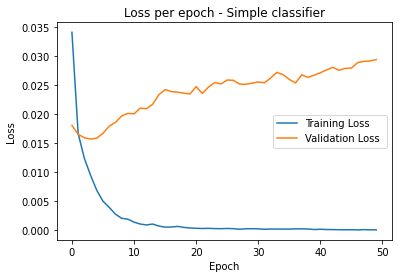

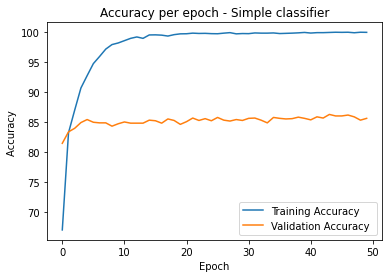

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats_vgg2[0],stats_vgg2[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats_vgg2[1],stats_vgg2[3],NUM_EPOCS,"Accuracy ",name)